In [1]:
import cv2
import os
import sys

def extract_and_split_frames(input_path, out_dir, img_ext='png'):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: cannot open video '{input_path}'")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    half_h = height // 2

    left_dir  = os.path.join(out_dir, 'left')
    right_dir = os.path.join(out_dir, 'right')
    os.makedirs(left_dir, exist_ok=True)
    os.makedirs(right_dir, exist_ok=True)

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        top    = frame[0:half_h,      0:width]
        bottom = frame[half_h:height, 0:width]

        left_path  = os.path.join(left_dir,  f"frame_{frame_idx:05d}.{img_ext}")
        right_path = os.path.join(right_dir, f"frame_{frame_idx:05d}.{img_ext}")

        cv2.imwrite(left_path,  top)
        cv2.imwrite(right_path, bottom)

        frame_idx += 1

    cap.release()
    print(f"Done. Extracted {frame_idx} frames to '{left_dir}' and '{right_dir}'.")

In [2]:
extract_and_split_frames("/content/rgb.mp4", "video_frames", "png")

Done. Extracted 197 frames to 'video_frames/left' and 'video_frames/right'.


--- Raw data loaded from YAML (first few keys): ---
  YAML Key: 'R', Type: <class 'dict'>, Value (partial): {'rows': 3, 'cols': 3, 'dt': 'f', 'data': [1.0, 1.94856493e-05, -0.000152324792, -1.95053162e-05, 1.
  YAML Key: 'T', Type: <class 'dict'>, Value (partial): {'rows': 1, 'cols': 3, 'dt': 'f', 'data': [-4.14339018, -0.0238197036, -0.00190685259]}
  YAML Key: 'M1', Type: <class 'dict'>, Value (partial): {'rows': 3, 'cols': 3, 'dt': 'f', 'data': [1035.30811, 0.0, 596.955017, 0.0, 1035.08765, 520.410034,
  YAML Key: 'D1', Type: <class 'dict'>, Value (partial): {'rows': 1, 'cols': 5, 'dt': 'f', 'data': [-0.000595157442, -0.000546629308, 0.0, 0.0, 0.00182959007
  YAML Key: 'alpha1', Type: <class 'float'>, Value (partial): 0.0
  YAML Key: 'M2', Type: <class 'dict'>, Value (partial): {'rows': 3, 'cols': 3, 'dt': 'f', 'data': [1035.17419, 0.0, 688.361877, 0.0, 1034.979, 521.070801, 0
  YAML Key: 'D2', Type: <class 'dict'>, Value (partial): {'rows': 1, 'cols': 5, 'dt': 'f', 'data': [-0.0002

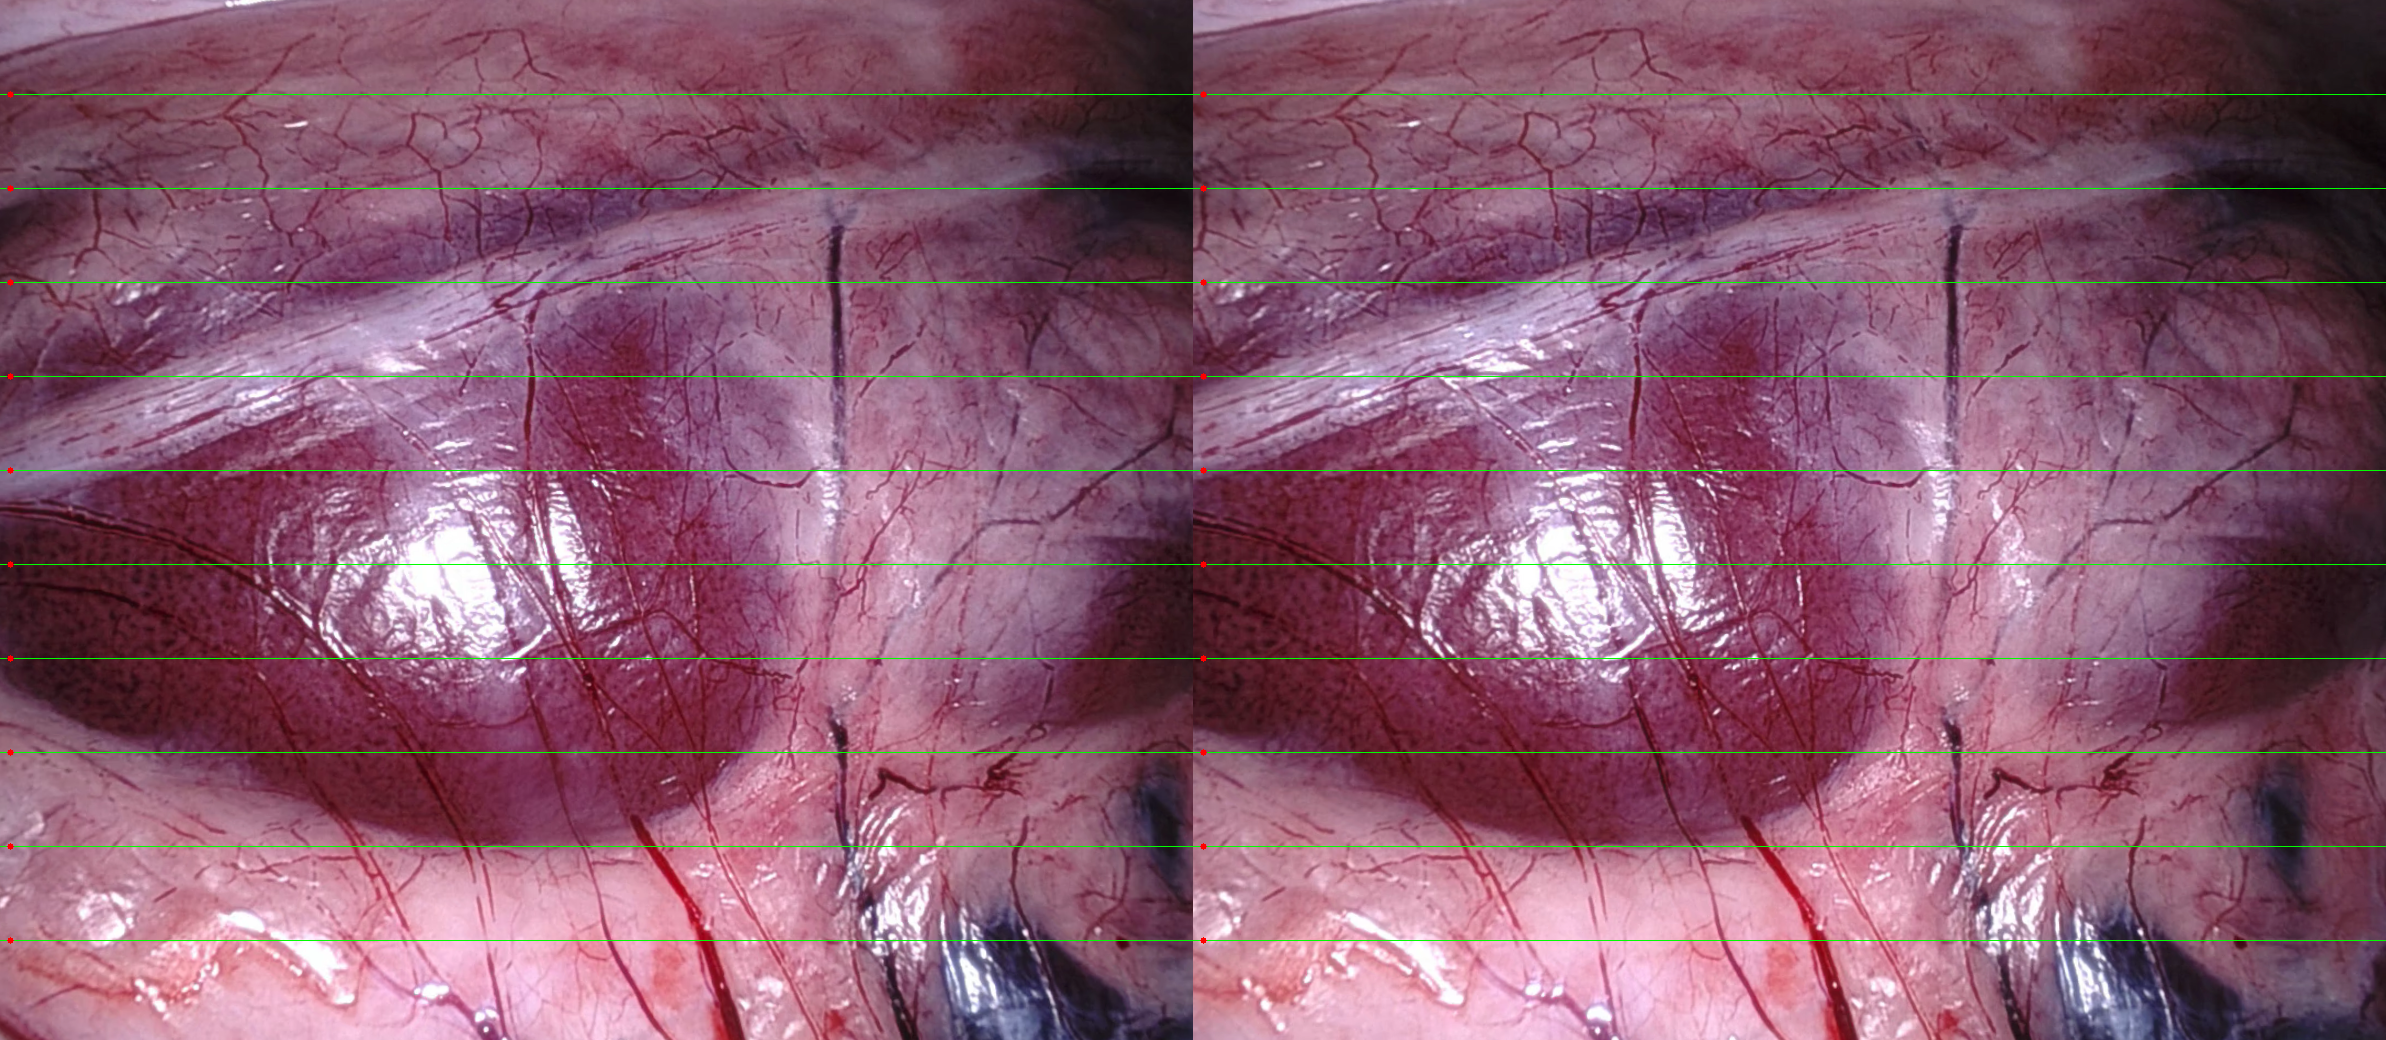

Processing pair 2/197: frame_00001.png & frame_00001.png
Processing pair 3/197: frame_00002.png & frame_00002.png
Processing pair 4/197: frame_00003.png & frame_00003.png
Processing pair 5/197: frame_00004.png & frame_00004.png
Processing pair 6/197: frame_00005.png & frame_00005.png
Processing pair 7/197: frame_00006.png & frame_00006.png
Processing pair 8/197: frame_00007.png & frame_00007.png
Processing pair 9/197: frame_00008.png & frame_00008.png
Processing pair 10/197: frame_00009.png & frame_00009.png
Processing pair 11/197: frame_00010.png & frame_00010.png
Processing pair 12/197: frame_00011.png & frame_00011.png
Processing pair 13/197: frame_00012.png & frame_00012.png
Processing pair 14/197: frame_00013.png & frame_00013.png
Processing pair 15/197: frame_00014.png & frame_00014.png
Processing pair 16/197: frame_00015.png & frame_00015.png
Processing pair 17/197: frame_00016.png & frame_00016.png
Processing pair 18/197: frame_00017.png & frame_00017.png
Processing pair 19/197

In [7]:
import cv2
import numpy as np
from pathlib import Path
import yaml
import os
import errno
import shutil

class Calibrator:
    def __init__(self, chessboard_size=None, tile_size=None):
        self.chessboard_size = chessboard_size
        self.tile_size = tile_size
        self.calib = {
            'cb_size': self.chessboard_size, 'tile_size': self.tile_size,
            'error': None, 'image_size': None, 'K': None, 'D': None,
            'rvecs': None, 'tvecs': None, 'K1': None, 'D1': None,
            'K2': None, 'D2': None, 'R': None, 'T': None, 'E': None, 'F': None,
            'R1': None, 'R2': None, 'P1': None, 'P2': None, 'Q': None,
            'roi1': None, 'roi2': None, 'rect_alpha': None
        }
        if chessboard_size and tile_size:
             self.obj_pts = self._create_chessboard_points()

    def _create_chessboard_points(self):
        if not self.chessboard_size or not self.tile_size: return None
        objp = np.zeros((self.chessboard_size[0] * self.chessboard_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:self.chessboard_size[0], 0:self.chessboard_size[1]].T.reshape(-1, 2)
        return objp * self.tile_size

    def _find_chessboard_corners(self, img):
        # This method would be used if performing calibration from scratch
        # For this script, we assume parameters are loaded.
        pass

    def save(self, path):
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        path_str = str(path)
        # Use cv2.FILE_STORAGE_WRITE_TEXT for human-readable YAML/XML if not default
        fs_write = cv2.FileStorage(path_str, cv2.FILE_STORAGE_WRITE) # Or cv2.FILE_STORAGE_WRITE_TEXT

        try: # Use try-finally to ensure release() is called
            for k, v in self.calib.items():
                if v is not None:
                    if k in ['cb_size', 'image_size'] and isinstance(v, tuple):
                        # Convert tuple of ints (like image_size) to a list or np.array for writing
                        # Using np.array with a specific dtype is often more robust.
                        fs_write.write(k, np.array(v, dtype=np.int32))
                    elif isinstance(v, (list, tuple)) and len(v) > 0 and all(isinstance(item, np.ndarray) for item in v):
                        # This handles lists/tuples of NumPy arrays (e.g., rvecs, tvecs)
                        # cv2.FileNode_SEQ creates a sequence (like a list in YAML)
                        # cv2.FileNode_FLOW makes it more compact (e.g., on one line if possible)
                        fs_write.startWriteStruct(k, cv2.FileNode_SEQ | cv2.FileNode_FLOW)
                        for i, item_array in enumerate(v):
                            # When writing items to a sequence, the 'name' argument to write should be None or an empty string.
                            # OpenCV will handle the sequence structure.
                            fs_write.write(None, item_array)
                        fs_write.endWriteStruct()
                    elif isinstance(v, (list, tuple)) and all(isinstance(item, (int, float, str)) for item in v):
                        # Handles other lists/tuples of simple scalars (ints, floats, strings)
                        # Converting to np.array can be more robust for FileStorage,
                        # but direct write of list of scalars usually works.
                        fs_write.write(k, np.array(v)) # Or just fs_write.write(k, v)
                    elif isinstance(v, (np.ndarray, int, float, str)):
                        # Handles individual NumPy arrays, integers, floats, strings
                        fs_write.write(k, v)
                    else:
                        print(f"Warning: Skipping key '{k}'. Value type {type(v)} is not directly supported by this save method for cv2.FileStorage. Value: {v}")
                # else:
                    # print(f"Skipping key '{k}' because its value is None.")

        finally:
            fs_write.release()

        print(f"OpenCV calibration data saved to {path_str}")

    def load_opencv_format(self, path):
        path_str = str(path)
        if not Path(path_str).is_file():
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), path_str)
        fs_read = cv2.FileStorage(path_str, cv2.FILE_STORAGE_READ)
        if not fs_read.isOpened(): raise IOError(f"Could not open OpenCV calibration file: {path_str}")

        for k in self.calib.keys():
            node = fs_read.getNode(k)
            if not node.empty():
                if k == 'K1': mat_val = node.mat(); self.calib[k] = fs_read.getNode('M1').mat() if (mat_val is None or mat_val.size == 0) else mat_val
                elif k == 'K2': mat_val = node.mat(); self.calib[k] = fs_read.getNode('M2').mat() if (mat_val is None or mat_val.size == 0) else mat_val
                elif k in ['cb_size', 'image_size']:
                    val = node.mat()
                    if val is not None: self.calib[k] = tuple(int(x) for x in val.flatten())
                elif node.isReal(): self.calib[k] = node.real()
                else: self.calib[k] = node.mat()
        fs_read.release()
        if self.calib.get('image_size') and isinstance(self.calib['image_size'], list):
            self.calib['image_size'] = tuple(self.calib['image_size'])
        print(f"OpenCV calibration data loaded from {path_str}")
        return self.calib

class StereoCalibrator(Calibrator):
    def __init__(self, chessboard_size=None, tile_size=None):
        super().__init__(chessboard_size, tile_size)
        self.left_rect_map = None
        self.right_rect_map = None
        self.rect_alpha = -1 # Default alpha for rectification
        self.calib['rect_alpha'] = self.rect_alpha

    def _compute_rectification_parameters(self, alpha=-1):
        self.rect_alpha = alpha
        self.calib['rect_alpha'] = alpha # Store it

        if self.calib['image_size'] is None:
            print("Error: Image size not set. Cannot compute rectification parameters.")
            return False
        if not all(self.calib.get(key) is not None for key in ['K1', 'D1', 'K2', 'D2', 'R', 'T']):
            print("Error: K1, D1, K2, D2, R, or T are missing for stereo rectification.")
            return False

        # Ensure T is 3x1 for stereoRectify
        T_rect = self.calib['T']
        if T_rect.shape == (1,3): T_rect = T_rect.T
        elif T_rect.shape != (3,1):
            print(f"Error: T vector has unexpected shape {T_rect.shape}. Expected (3,1) or (1,3).")
            return False

        R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
            self.calib['K1'], self.calib['D1'],
            self.calib['K2'], self.calib['D2'],
            tuple(self.calib['image_size'][::-1]), # (width, height)
            self.calib['R'].astype(np.float64),
            T_rect.astype(np.float64),
            alpha=self.rect_alpha,
            flags=cv2.CALIB_ZERO_DISPARITY,
            newImageSize=tuple(self.calib['image_size'][::-1])
        )
        self.calib.update({'R1': R1, 'R2': R2, 'P1': P1, 'P2': P2, 'Q': Q, 'roi1': roi1, 'roi2': roi2})
        print(f"Rectification parameters computed with alpha: {self.rect_alpha}")
        self.left_rect_map = None # Invalidate maps
        self.right_rect_map = None
        return True

    def rectify(self, left_img, right_img, alpha=None):
        if alpha is not None and alpha != self.rect_alpha:
            print(f"Alpha changed. Recomputing rectification parameters for alpha={alpha}.")
            if not self._compute_rectification_parameters(alpha=alpha):
                print("Failed to compute rectification parameters with new alpha.")
                return left_img, right_img # Return originals
        elif self.calib.get('R1') is None: # If R1 is not there, params likely not computed
            print("Rectification parameters (R1, P1, etc.) not found. Computing them now.")
            if not self._compute_rectification_parameters(alpha=self.rect_alpha): # Use stored or default alpha
                print("Failed to compute initial rectification parameters.")
                return left_img, right_img

        # Ensure image_size is set, prefer from calibration, else from image
        current_img_size = left_img.shape[:2]
        if self.calib['image_size'] is None:
            self.calib['image_size'] = current_img_size
            print(f"Image size set from input image: {self.calib['image_size']}")
            # Force recompute if image_size was just defined based on input
            if not self._compute_rectification_parameters(alpha=self.rect_alpha):
                 return left_img, right_img
        elif tuple(self.calib['image_size']) != current_img_size:
            print(f"Warning: Input image size {current_img_size} differs from calibrated {self.calib['image_size']}.")
            # Potentially recompute rectification parameters for new image size if desired
            # For now, we proceed with maps based on self.calib['image_size']

        if self.left_rect_map is None or self.right_rect_map is None:
            if not all(self.calib.get(key) is not None for key in ['K1', 'D1', 'R1', 'P1', 'K2', 'D2', 'R2', 'P2']):
                print("Error: Missing parameters for initUndistortRectifyMap. Cannot rectify.")
                if not self._compute_rectification_parameters(alpha=self.rect_alpha): # Try to compute again
                    return left_img, right_img
                if not all(self.calib.get(key) is not None for key in ['K1', 'D1', 'R1', 'P1', 'K2', 'D2', 'R2', 'P2']):
                    return left_img, right_img # Still missing

            print("Initializing undistortion rectification maps...")
            self.left_rect_map = cv2.initUndistortRectifyMap(
                self.calib['K1'], self.calib['D1'], self.calib['R1'], self.calib['P1'],
                tuple(self.calib['image_size'][::-1]), cv2.CV_32FC1)
            self.right_rect_map = cv2.initUndistortRectifyMap(
                self.calib['K2'], self.calib['D2'], self.calib['R2'], self.calib['P2'],
                tuple(self.calib['image_size'][::-1]), cv2.CV_32FC1)

        left_rect = cv2.remap(left_img, self.left_rect_map[0], self.left_rect_map[1], cv2.INTER_LINEAR)
        right_rect = cv2.remap(right_img, self.right_rect_map[0], self.right_rect_map[1], cv2.INTER_LINEAR)
        return left_rect, right_rect

    def load_generic_endoscope_yaml(self, yaml_path):
      """Loads parameters from the SCARED-like YAML and populates self.calib."""
      if not Path(yaml_path).exists():
          print(f"Error: Calibration YAML file not found at '{yaml_path}'. Please upload it.")
          return False

      def unknown_tag_constructor(loader, tag_suffix, node):
          if isinstance(node, yaml.MappingNode): return loader.construct_mapping(node)
          if isinstance(node, yaml.SequenceNode): return loader.construct_sequence(node)
          return loader.construct_scalar(node)

      yaml.add_multi_constructor('', unknown_tag_constructor, Loader=yaml.SafeLoader)

      with open(yaml_path, 'r') as f:
          data = yaml.load(f, Loader=yaml.SafeLoader)
          # --- DEBUGGING YAML CONTENT ---
          print("--- Raw data loaded from YAML (first few keys): ---")
          for i, (key, value) in enumerate(data.items()):
              print(f"  YAML Key: '{key}', Type: {type(value)}, Value (partial): {str(value)[:100]}")
              if i > 5: # Print first few for brevity
                  break
          print("----------------------------------------------------")
          # --- END DEBUGGING ---


      def parse_cv_matrix_from_dict(value_dict):
          if isinstance(value_dict, dict) and 'rows' in value_dict and 'cols' in value_dict and 'data' in value_dict:
              try:
                  rows, cols = value_dict['rows'], value_dict['cols']
                  dt_str = value_dict.get('dt', 'f')
                  if dt_str == 'f': dt = np.float32
                  elif dt_str == 'd': dt = np.float64
                  elif dt_str == 'i': dt = np.int32
                  else:
                      print(f"Warning: Unknown data type '{dt_str}' in matrix, defaulting to float32.")
                      dt = np.float32
                  mat_data = np.array(value_dict['data'], dtype=dt)
                  return mat_data.reshape(rows, cols)
              except Exception as e:
                  print(f"Could not parse matrix from dict: {e}, dict was: {value_dict}")
          elif value_dict is not None:
              print(f"Warning: Expected a dictionary with matrix structure for parsing, but got: {type(value_dict)}")
          return None

      self.calib['K1'] = parse_cv_matrix_from_dict(data.get('M1'))
      self.calib['D1'] = parse_cv_matrix_from_dict(data.get('D1'))
      self.calib['K2'] = parse_cv_matrix_from_dict(data.get('M2'))
      self.calib['D2'] = parse_cv_matrix_from_dict(data.get('D2'))
      self.calib['R'] = parse_cv_matrix_from_dict(data.get('R'))
      self.calib['T'] = parse_cv_matrix_from_dict(data.get('T'))

      # --- DEBUGGING image_size ---
      img_s_raw = data.get('image_size')
      print(f"DEBUG: Raw value for 'image_size' from YAML: {img_s_raw} (Type: {type(img_s_raw)})")
      # --- END DEBUGGING ---

      img_s = data.get('image_size') # Get it again for the actual logic
      if isinstance(img_s, list) and len(img_s) == 2:
          try:
              self.calib['image_size'] = tuple(map(int, img_s)) # Ensure integers
              print(f"DEBUG: 'image_size' successfully parsed from YAML as: {self.calib['image_size']}")
          except ValueError:
              print(f"DEBUG: ValueError converting elements of 'image_size' ({img_s}) to int. Will try to infer.")
              self.calib['image_size'] = None # Ensure it's None so fallback can happen
      else:
          print(f"DEBUG: 'image_size' from YAML is not a list of 2 elements or is None. Raw value was: {img_s}")
          self.calib['image_size'] = None # Ensure it's None for fallback if condition not met


      if self.calib['image_size'] is None: # Fallback logic
          if self.calib['K1'] is not None :
              h_approx = int(self.calib['K1'][1,2] * 2)
              w_approx = int(self.calib['K1'][0,2] * 2)
              self.calib['image_size'] = (h_approx, w_approx)
              print(f"Warning: 'image_size' was not successfully parsed from YAML, inferred as {self.calib['image_size']} from K1.")
          else:
              print("Warning: 'image_size' not in YAML/invalid and K1 is not available to infer it.")


      if not all(self.calib.get(k) is not None for k in ['K1', 'D1', 'K2', 'D2', 'R', 'T']):
          print("Error: Critical parameters missing after loading generic YAML.")
          for k_check in ['K1', 'D1', 'K2', 'D2', 'R', 'T']:
              if self.calib.get(k_check) is None: print(f"  Missing: {k_check}")
          return False
      print(f"Generic endoscope YAML parameters loaded from {yaml_path}")
      return True

# --- Helper function to draw epilines for display ---
def draw_epilines_on_rectified(left_rect, right_rect, num_lines=10):
    """Draws horizontal lines on a copy of the rectified images."""
    display_l = left_rect.copy()
    display_r = right_rect.copy()
    h, w = display_l.shape[:2]
    interval = h // (num_lines + 1)
    for i in range(1, num_lines + 1):
        y = i * interval
        cv2.line(display_l, (0, y), (w, y), (0, 255, 0), 1)
        cv2.line(display_r, (0, y), (w, y), (0, 255, 0), 1)
        cv2.circle(display_l, (10,y), 3, (0,0,255), -1)
        cv2.circle(display_r, (10,y), 3, (0,0,255), -1)
    return display_l, display_r

# --- Main Colab Execution ---
def run_colab_rectification():
    # --- Configuration ---
    GENERIC_YAML_FILENAME = "endoscope_calibration.yaml"  # The name of your uploaded YAML

    # Input image directories
    INPUT_VIDEO_FRAMES_DIR = Path("./video_frames")
    INPUT_LEFT_DIR = INPUT_VIDEO_FRAMES_DIR / "left"
    INPUT_RIGHT_DIR = INPUT_VIDEO_FRAMES_DIR / "right"

    # Output directories for rectified frames
    OUTPUT_RECTIFIED_BASE_DIR = Path("./rectified_video_frames")
    OUTPUT_LEFT_RECT_DIR = OUTPUT_RECTIFIED_BASE_DIR / "left"
    OUTPUT_RIGHT_RECT_DIR = OUTPUT_RECTIFIED_BASE_DIR / "right"

    # Clean and create output directories
    if OUTPUT_RECTIFIED_BASE_DIR.exists():
        shutil.rmtree(OUTPUT_RECTIFIED_BASE_DIR) # Remove old rectified frames
    OUTPUT_LEFT_RECT_DIR.mkdir(parents=True, exist_ok=True)
    OUTPUT_RIGHT_RECT_DIR.mkdir(parents=True, exist_ok=True)

    OPENCV_CALIB_OUTPUT_FILENAME = "stereo_calib_opencv_format.yaml"

    # --- Check if required files/directories exist (user must upload/create these) ---
    if not Path(GENERIC_YAML_FILENAME).exists():
        print(f"ERROR: Calibration file '{GENERIC_YAML_FILENAME}' not found.")
        print("Please upload your endoscope calibration YAML file to the Colab session.")
        return

    if not INPUT_LEFT_DIR.is_dir():
        print(f"ERROR: Input directory for left images '{INPUT_LEFT_DIR}' not found.")
        print(f"Please create it and upload your left images there (e.g., inside a '{INPUT_VIDEO_FRAMES_DIR}' folder).")
        return

    if not INPUT_RIGHT_DIR.is_dir():
        print(f"ERROR: Input directory for right images '{INPUT_RIGHT_DIR}' not found.")
        print(f"Please create it and upload your right images there (e.g., inside a '{INPUT_VIDEO_FRAMES_DIR}' folder).")
        return

    # Get sorted lists of image paths
    # Supported image extensions, add more if needed
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']
    left_image_paths = []
    for ext in image_extensions:
        left_image_paths.extend(sorted(INPUT_LEFT_DIR.glob(ext)))

    right_image_paths = []
    for ext in image_extensions:
        right_image_paths.extend(sorted(INPUT_RIGHT_DIR.glob(ext)))


    if not left_image_paths:
        print(f"ERROR: No images found in '{INPUT_LEFT_DIR}'.")
        return
    if not right_image_paths:
        print(f"ERROR: No images found in '{INPUT_RIGHT_DIR}'.")
        return
    if len(left_image_paths) != len(right_image_paths):
        print(f"ERROR: Mismatch in number of images in left ({len(left_image_paths)}) and right ({len(right_image_paths)}) directories.")
        print("Please ensure there is a corresponding image for every left/right pair and they sort consistently.")
        return
    # --- End File Checks ---

    stereo_cal = StereoCalibrator()

    if not stereo_cal.load_generic_endoscope_yaml(GENERIC_YAML_FILENAME):
        print("Failed to load or parse endoscope calibration YAML. Exiting.")
        return

    rectification_alpha = 0.0  # Or -1, or 1.0 - experiment with this
    # Compute rectification parameters ONCE, using the image_size from the YAML or first image.
    # This assumes all images in the sequence have the same dimensions as specified in calibration.
    # If image_size is not in YAML, it will be inferred from the first image pair.
    if stereo_cal.calib['image_size'] is None and left_image_paths:
        first_left_img_for_size = cv2.imread(str(left_image_paths[0]))
        if first_left_img_for_size is not None:
            stereo_cal.calib['image_size'] = first_left_img_for_size.shape[:2]
            print(f"Image size for rectification set from first image: {stereo_cal.calib['image_size']}")
        else:
            print(f"Could not read first left image {left_image_paths[0]} to determine image size.")
            return


    if not stereo_cal._compute_rectification_parameters(alpha=rectification_alpha):
        print("Failed to compute stereo rectification parameters. Exiting.")
        return

    stereo_cal.save(OPENCV_CALIB_OUTPUT_FILENAME) # Save the full calibration including R1,P1 etc.

    print(f"\nProcessing {len(left_image_paths)} image pairs...")

    for i, (left_path, right_path) in enumerate(zip(left_image_paths, right_image_paths)):
        print(f"Processing pair {i+1}/{len(left_image_paths)}: {left_path.name} & {right_path.name}")

        left_img = cv2.imread(str(left_path))
        right_img = cv2.imread(str(right_path))

        if left_img is None:
            print(f"  Warning: Could not load left image '{left_path}'. Skipping pair.")
            continue
        if right_img is None:
            print(f"  Warning: Could not load right image '{right_path}'. Skipping pair.")
            continue

        # Rectify the current pair
        # The rectification maps (left_rect_map, right_rect_map) are computed once
        # by _compute_rectification_parameters and reused by rectify() unless alpha changes.
        left_rect, right_rect = stereo_cal.rectify(left_img, right_img, alpha=rectification_alpha)

        # Construct output filenames
        base_left_name = left_path.stem
        ext_left_name = left_path.suffix
        base_right_name = right_path.stem
        ext_right_name = right_path.suffix

        cv2.imwrite(str(OUTPUT_LEFT_RECT_DIR / f"{base_left_name}_rectified{ext_left_name}"), left_rect)
        cv2.imwrite(str(OUTPUT_RIGHT_RECT_DIR / f"{base_right_name}_rectified{ext_right_name}"), right_rect)

        # Display the first rectified pair as an example
        if i == 0:
            print("\nDisplaying the first rectified pair as an example:")
            try:
                from google.colab.patches import cv2_imshow
                left_rect_display, right_rect_display = draw_epilines_on_rectified(left_rect, right_rect)
                combined_rectified_display = np.hstack((left_rect_display, right_rect_display))
                print(f"--- Rectified Pair (alpha={rectification_alpha}) ---")
                cv2_imshow(combined_rectified_display)
            except ImportError:
                print("  google.colab.patches.cv2_imshow not available for display.")

    print(f"\nAll images processed. Rectified frames saved to '{OUTPUT_LEFT_RECT_DIR}' and '{OUTPUT_RIGHT_RECT_DIR}'")

if __name__ == "__main__":
    run_colab_rectification()

## Rectification **Version 2**

Include the image size inside the YAML file like this: image_size : [1024, 1280]